# Auto Encoders
Author: Soham Vaishnav\
Roll No.: 2022112002

## Importing libraries

In [1]:
import numpy as np
from plotly import express as px
from plotly import subplots as sp
from plotly import graph_objects as go
from matplotlib import pyplot as plt
import pandas as pd
import sys
import os
import wandb

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torchvision.transforms as transforms

## Setting up paths

In [2]:

AssignDIR = os.path.dirname(os.path.dirname(os.path.abspath('AutoEncoder.ipynb')))
CurrDIR = os.path.dirname(os.path.abspath('AutoEncoder.ipynb'))
UserDIR = os.path.dirname(AssignDIR)

sys.path.append(UserDIR)

RawDataDIR = os.path.join(UserDIR, "./data/external/")
PreProcessDIR = os.path.join(UserDIR, "./data/interim/4/")

from utils_4 import *
from models.AutoEncoders import auto_encoder, cnn_autoencoder, pca_autoencoder

## Dataloading

In [3]:
loader = FashionMNISTLoader(batch_size=64)

train_loader, val_loader, test_loader = loader.load_data()

## Visualising the Dataset

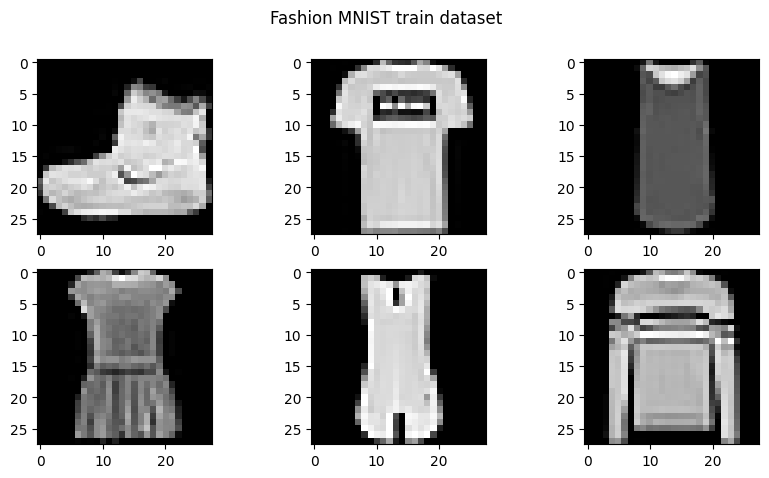

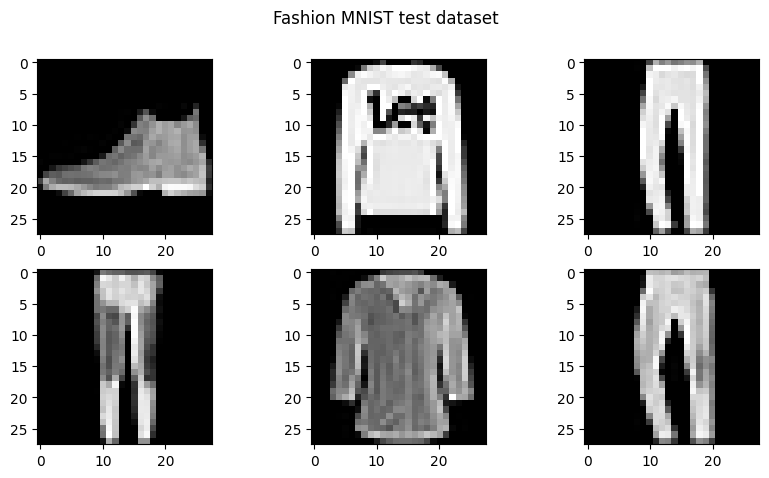

In [4]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Fashion MNIST train dataset')
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(train_loader.dataset.dataset.images[i], cmap='gray')
plt.show()

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Fashion MNIST test dataset')
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_loader.dataset.images[i], cmap='gray')
plt.show()

## Initialising the model

In [5]:
config_model = {'task': [], 'in_channels': [], 'ConvLayers': [], 'FCLayers': [], 'pool': [], 
                'kernel_size': [], 'strides': [], 'activation': [], 'dropout': []}

config_trainer = {'model': [], 'loss': [], 'epochs': [], 'batch_size': [], 'learning_rate': [], 
                  'optimizer': [], 'wandb': False, 'labels': [], 'labelsRnum': True, 'FM_Vis': False}

## CNN Autoencoder

### Running the model

In [6]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# batch_size = 64
# learning_rate = 1e-3
# num_epochs = 10

# model = cnn_autoencoder.CnnAutoencoder().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# def train(model, loader):
#     model.train()
#     running_loss = 0.0
#     for images, _ in loader:
#         images = images.to(device)

#         outputs = model(images)
#         loss = criterion(outputs, images)

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         running_loss += loss.item()
#     return running_loss / len(loader.dataset)

# def validate(model, loader):
#     model.eval()
#     running_loss = 0.0
#     with torch.no_grad():
#         for images, _ in loader:
#             images = images.to(device)

#             outputs = model(images)
#             loss = criterion(outputs, images)

#             running_loss += loss.item()
#     return running_loss / len(loader.dataset)

def test_and_visualize(model, loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        images = images.to(device)

        outputs = model(images)

        images = images.cpu().numpy()
        outputs = outputs.cpu().numpy()

        fig, axes = plt.subplots(2, 6, figsize=(12, 4))
        for i in range(6):
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')

            axes[1, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis('off')
        plt.show()

# for epoch in range(num_epochs):
#     train_loss = train(model, train_loader)
#     val_loss = validate(model, val_loader)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# test_and_visualize(model, test_loader)
from tqdm import tqdm

batch_size = 64
data_loader = FashionMNISTLoader(batch_size=batch_size)
train_loader, val_loader, test_loader = data_loader.load_data()

# config = {'in_channels': 1, 'latent_dim': 16, 'kernel_size': [], 
# 'stride': [], 'padding': [], 'pool': [], 'pool_stride': []}
model = cnn_autoencoder.CnnAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, _ in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc="Validating", leave=False):
            images = images.to(device)

            outputs = model(images)
            loss = criterion(outputs, images)

            total_loss += loss.item()

    return total_loss / len(val_loader.dataset)

def test(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)

            outputs = model(images)

    print("Testing completed.")

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

test(model, test_loader, device)

# torch.save(model.state_dict(), "cnn_autoencoder.pth")
print("Model saved successfully.")

test_and_visualize(model, test_loader)


Epoch [1/10], Train Loss: 0.0110, Val Loss: 0.0051


KeyboardInterrupt: 

## PCA Autoencoder

### Running code

Components: 64, Validation MSE: 0.0410


ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

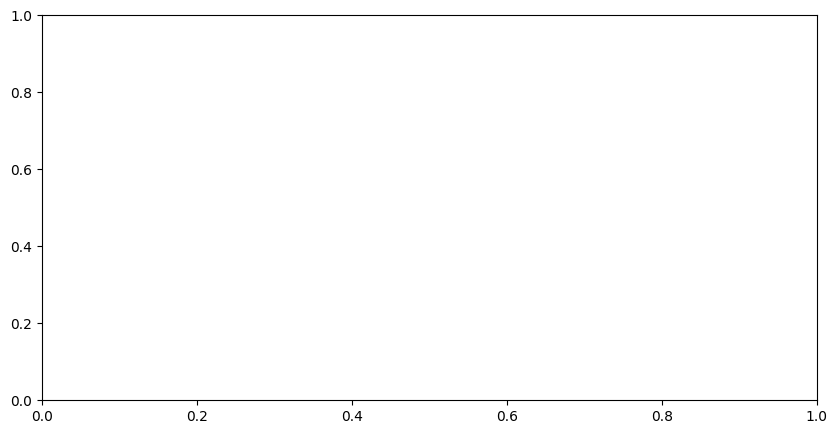

In [ ]:
batch_size = 32
root = RawDataDIR
input_dim = 28 * 28
max_components = 20

data_loader = FashionMNISTLoader(batch_size=batch_size, root=root)
train_loader, val_loader, test_loader = data_loader.load_data()

pca_ae = pca_autoencoder.PcaAutoencoder(input_dim=input_dim, output_dim=max_components)

def plot_elbow_curve(errors, components):
    plt.figure(figsize=(10, 5))
    plt.plot(components, errors, marker='o')
    plt.title('Elbow Curve: Reconstruction Error vs. Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.grid()
    plt.show()

train_errors = []
components = list(range(1, max_components + 1))

all_train_images = []
for images, _ in train_loader:
    all_train_images.append(images.view(-1, input_dim))

all_train_images = torch.cat(all_train_images)

for k in components:
    pca_ae.output_dim = k
    pca_ae.fit(all_train_images)

    val_errors = []
    for val_images, _ in val_loader:
        val_images_flat = val_images.view(-1, input_dim)
        reconstructed = pca_ae.forward(val_images_flat)
        error = pca_ae.calculate_reconstruction_error(val_images_flat, reconstructed)
        val_errors.append(error.item())

    mean_val_error = np.mean(val_errors)
    train_errors.append(mean_val_error)
    print(f"Components: {k}, Validation MSE: {mean_val_error:.4f}")

plot_elbow_curve(train_errors, components)

optimal_components = components[np.argmin(train_errors)]
print(f"Optimal number of components: {optimal_components}")

pca_ae.eval()
test_imgs = []
for test_images, _ in test_loader:
    test_images_flat = test_images.view(-1, input_dim)
    reconstructed = pca_ae(test_images_flat).detach()

    test_imgs.append(test_images)
    test_imgs.append(reconstructed.view(-1, 1, 28, 28))

def plot_images(original, reconstructed, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.show()

original_images = test_imgs[0][:6]
reconstructed_images = test_imgs[1][:6]
plot_images(original_images, reconstructed_images)


## MLP Autoencoder

### Running Code

In [ ]:
config = {'learning_rate': [], 'epochs': [], 'batch_size': [], 'optimizer': [], 'grad_verify': False, 
                       'loss': [], 'layers': [], 'activations': [], 'type': model, 'wb': False}
config['learning_rate'] = 0.01
config['epochs'] = 1
config['activations'] = 'relu'
config['batch_size'] = 256
config['layers'] = [784, 1, 784]
config['loss'] = 'mse'
config['optimizer'] = 'sgd'
mlp_ae = auto_encoder.AutoEncoder(config)

X_train = []
for images, _ in train_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_train.append(i)

X_train = np.array(X_train)

X_val = []
for images, _ in val_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_val.append(i)

X_val = np.array(X_val)

X_test = []
for images, _ in test_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_test.append(i)

X_test = np.array(X_test)

mlp_ae.fit(X_train, X_train, X_val, X_val)
print(mlp_ae.evaluate(X_test, X_test))

Epoch:  0


KeyboardInterrupt: 

## KNN 

In [17]:
train_labels = []
for _,label in train_loader:
    train_labels.append(label)
train_labels = torch.cat(train_labels)
train_labels = train_labels.numpy()

val_labels = []
for _,label in val_loader:
    val_labels.append(label)
val_labels = torch.cat(val_labels)
val_labels = val_labels.numpy()

test_labels = []
for _,label in test_loader:
    test_labels.append(label)
test_labels = torch.cat(test_labels)
test_labels = test_labels.numpy()

### Reducing features

#### Using PCA Autoencoder

In [15]:
input_dim = 28*28

all_train_images = []
for images, _ in train_loader:
    all_train_images.append(images.view(-1, input_dim))

all_train_images = torch.cat(all_train_images)

all_val_images = []
for images, _ in val_loader:
    all_val_images.append(images.view(-1, input_dim))

all_val_images = torch.cat(all_val_images)

all_test_images = []
for images, _ in test_loader:
    all_test_images.append(images.view(-1, input_dim))

all_test_images = torch.cat(all_test_images)

pca_ae = pca_autoencoder.PcaAutoencoder(28*28, 7)
pca_ae.fit(all_train_images)

X_train_pca = []
for i in all_train_images:
    i = i.reshape((1, -1))
    out = pca_ae.encode(i)
    X_train_pca.append(out.numpy().reshape(-1))
X_train_pca = np.array(X_train_pca)
print(X_train_pca.shape)

X_val_pca = []
for i in all_val_images:
    i = i.reshape((1, -1))
    out = pca_ae.encode(i)
    X_val_pca.append(out.numpy().reshape(-1))
X_val_pca = np.array(X_val_pca)
print(X_val_pca.shape)

X_test_pca = []
for i in all_test_images:
    i = i.reshape((1, -1))
    out = pca_ae.encode(i)
    X_test_pca.append(out.numpy().reshape(-1))
X_test_pca = np.array(X_test_pca)
print(X_test_pca.shape)

(48000, 7)
(12000, 7)
(10000, 7)


#### Using CNN Autoencoder

In [14]:
X = []
model = cnn_autoencoder.CnnAutoencoder()

for images, _ in train_loader:
    X.append(images)
X = torch.cat(X)
X_train_cnn = []
for image in X:
    X_train_cnn.append(model.encode(image).detach().numpy().reshape(-1))
X_train_cnn = np.array(X_train_cnn)
print(X_train_cnn.shape)

X = []
for images, _ in val_loader:
    X.append(images)
X = torch.cat(X)
X_val_cnn = []
for image in X:
    X_val_cnn.append(model.encode(image).detach().numpy().reshape(-1))
X_val_cnn = np.array(X_val_cnn)
print(X_val_cnn.shape)

X = []
for images, _ in test_loader:
    X.append(images)
X = torch.cat(X)
X_test_cnn = []
for image in X:
    X_test_cnn.append(model.encode(image).detach().numpy().reshape(-1))
X_test_cnn = np.array(X_test_cnn)
print(X_test_cnn.shape)

(48000, 7)
(12000, 7)
(10000, 7)


#### MLP Autoencoder

In [12]:
config = {'learning_rate': [], 'epochs': [], 'batch_size': [], 'optimizer': [], 'grad_verify': False, 
                       'loss': [], 'layers': [], 'activations': [], 'type': model, 'wb': False}
config['learning_rate'] = 0.01
config['epochs'] = 5
config['activations'] = 'relu'
config['batch_size'] = 256
config['layers'] = [256, 7, 256, 784]
config['loss'] = 'mse'
config['optimizer'] = 'sgd'
mlp_ae = auto_encoder.AutoEncoder(config)

X_train = []
for images, _ in train_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_train.append(i)

X_train = np.array(X_train)

X_val = []
for images, _ in val_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_val.append(i)

X_val = np.array(X_val)

X_test = []
for images, _ in test_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_test.append(i)

X_test = np.array(X_test)

mlp_ae.fit(X_train, X_train, X_val, X_val)
print(mlp_ae.evaluate(X_test, X_test))

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
{'loss': 0.09176357006313765, 'mse': 0.09176357006313765, 'rmse': 0.3029250238312075, 'r2': 0.7412597625604133}


In [13]:
X_train_mlp = mlp_ae.get_latent(X_train)
X_val_mlp = mlp_ae.get_latent(X_val)
X_test_mlp = mlp_ae.get_latent(X_test)

print(X_train_mlp.shape, X_val_mlp.shape, X_test_mlp.shape)

(48000, 7) (12000, 7) (10000, 7)


### Running the model

In [21]:
from models.knn.knn import *
import time

X_train_cnn = pd.DataFrame(X_train_cnn)
X_val_cnn = pd.DataFrame(X_val_cnn)
X_test_cnn = pd.DataFrame(X_test_cnn)

X_train_pca = pd.DataFrame(X_train_pca)
X_val_pca = pd.DataFrame(X_val_pca)
X_test_pca = pd.DataFrame(X_test_pca)

X_train_mlp = pd.DataFrame(X_train_mlp)
X_val_mlp = pd.DataFrame(X_val_mlp)
X_test_mlp = pd.DataFrame(X_test_mlp)

train_labels = pd.DataFrame(train_labels)
val_labels = pd.DataFrame(val_labels)
test_labels = pd.DataFrame(test_labels)

knn = KNN()
time_start = time.time()
knn.fit(X_train_mlp, train_labels)
knn.SetNumNeighbors(15)
knn.SetDistMetric('l1')
knn.FindDistances(X_val_mlp, 'optimised')
y_pred, acc, prec, recall, f1 = knn.predict(X_val_mlp, val_labels)
time_end = time.time()
print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Time taken: ", time_end - time_start)

Accuracy:  8.4
Precision:  (0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 0.0870430968279241, 0.084, 